# Bag of Words: Ham versus Spam

## Overview

In this lab, we will attempt to take the lessons learned from the IMDB classification using bag of words and apply them to  a binary classification of ham versus spam.

## Goals

By the end of this lab, you should be able to:

 * Implement a bag of words approach for a binary regression
 * Understand the fundamentals of tuning the hyperparameters for a model
 * Understand the roll of batch size and epochs
 
## Estimated Time: 45 - 60 minutes

# Obtaining the Data

The data for this lab is stored in the `../data/Enron` directory relative to this notebook.  Within that directory, the data has been preprocessed into a `ham` and `spam` directory with subdirectories that identify users.

# <img src="../images/task.png" width=20 height=20> Task 3.1

Please use the following cell to:
 * Import the *numpy* library with the typical `np` alias
 * Import the *pyplot* package from *matplotlib* using the typical `plt` alias
 * Import *datetime*
 * Import *os*, which we will need to list the files and directories that contain our data
 * Import *re*, which we will use for some regular expression manipulation
 * Either import any utility library you've created or paste in the code developed previously for plotting training history data
 * Import *tensorflow* as `tf`
 * Import the `models` and `layers` packages from `tensorflow.keras`

In [1]:
import numpy as np
import os
import datetime
import re
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt


2023-12-27 09:46:55.382195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 09:46:55.382264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 09:46:55.383458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 09:46:55.466624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_history(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    (figure, axes) = plt.subplots(1,2,figsize=(10,4), dpi=300)
    axes[0].plot(accuracy, label="Training")
    axes[0].plot(val_accuracy, label="Validation")
    axes[0].legend()
    axes[0].set_xlabel("Epoch")
    axes[0].grid()
    axes[0].set_title("Accuracy")
    axes[1].plot(loss, label="Training")
    axes[1].plot(val_loss, label="Validation")
    axes[1].legend()
    axes[1].set_xlabel("Epoch")
    axes[1].grid()
    axes[1].set_title("Loss")
    plt.show()

Now that we have our libraries imported, let's have a look at our data.

# <img src="../images/task.png" width=20 height=20> Task 3.2

Implement a Python function named `get_file_list()` that returns a list of all of the files, with paths, found in the `../data/Enron/` directory.  Verify that your function returns a list of 31,720 files with paths.  Your function should accept a starting directory name as an argument rather than use a fixed directory.

In [3]:
def get_file_list(starting_directory="../data/Enron/"):
    final_list = list()
    files = os.listdir(starting_directory)
    for file in files:
        file_name = os.path.join(starting_directory, file)
        if os.path.isdir(file_name):
            final_list = final_list + get_file_list(file_name)
        else:
            final_list.append(file_name)
    return final_list

In [4]:
all_files = get_file_list()
print(len(all_files))
print(all_files[:5], all_files[-5:])

31716
['../data/Enron/spam/BG/2004/08/1091394636.25221_97.txt', '../data/Enron/spam/BG/2004/08/1091477370.8044_889.txt', '../data/Enron/spam/BG/2004/08/1091639668.6258_15.txt', '../data/Enron/spam/BG/2004/08/1091477330.8044_383.txt', '../data/Enron/spam/BG/2004/08/1091394679.25221_221.txt'] ['../data/Enron/ham/kitchen-l/_americas_gas/53', '../data/Enron/ham/kitchen-l/_americas_gas/38', '../data/Enron/ham/kitchen-l/_americas_gas/6', '../data/Enron/ham/kitchen-l/_americas_gas/59', '../data/Enron/ham/kitchen-l/_americas_gas/28']


Now that we have the list of files, we're ready to work on our next task: retrieving all of the words that make up the body of each email in each file.

# <img src="../images/task.png" width=20 height=20> Task 3.3

Implement a function named `get_words()` in Python that extracts all of the words from the bodies of the emails found in a file.  The function should accept the filename/path as an input argument and return a list of all of the words found in that file that are a part of the email body.  All of the words should be forced to lowercase.

***Hint:*** You need to identify some string in each file that delineates where the headers end and the body of the email begins.  You should use this information to identify the body of the email text that you are returning.

***Hint:*** There is no need to make this list unique!  In fact, we do not *want* it to be unique.  Remember that in a bag of words approach, we need to work out a dictionary that will be sorted from most common to least commonly used words.  To properly build this dictionary we must have all of the words, not just the unique words in a message.

***Hint:*** When opening the file, you may find it advantageous to use the `encoding='utf-8'` keyword argument to force the encoding.  Additionally, the `errors='ignore'` option can allow us to disregard invalid UTF sequences.  Since our goal is to read in the words rather than read and display the email content, we're not overly concerned over losing a handful of words or characters due to weird encoding schemes.

In [5]:
def get_words(file_name):
    # We'll use a regular expression to find things that are not words or spaces.
    regex = re.compile("[^\w\s]")
    # Start with an empty list
    words = list()
    # Open the specified file
    with open(file_name, encoding='utf8', errors='ignore') as f:
        # Grab all of the lines
        text = f.readlines()
        # Set a flag to keep track of whether we have reached the body or not.
        finished_header = False
        # Iterate over the lines
        for line in text:
            # The last line in the headers is consistently the subject line.  If
            # we have not yet seen the subject then we are still parsing headers
            # and should ignore them.
            if finished_header:
                # If we have seen subject line, let's strip out things that aren't words
                # spaces, lowercase the line, and split it on whitespace.  Each word in
                # this list is then appended to the accumulating word list.
                for word in re.sub(regex, '', line.lower()).split():
                    words.append(word)
            # Check to see if the beginning of the line contains "subject:"
            # to determine if we have reached the end of the email header.
            elif line.lower() == "\n":
                # If we have, set the flag
                finished_header = True
    return words

In [6]:
get_words('../data/Enron/ham/lokay-m/enron_t_s/25')

['notice',
 'to',
 'all',
 'ets',
 'personnel',
 'on',
 'october',
 '11',
 '2000',
 'each',
 'of',
 'the',
 'enron',
 'pipelines',
 'will',
 'file',
 'for',
 'ferc',
 'approval',
 'of',
 'a',
 'new',
 'set',
 'of',
 'standards',
 'of',
 'conduct',
 'under',
 'the',
 'fercs',
 'marketing',
 'affiliate',
 'rule',
 'please',
 'go',
 'to',
 'wwwotsenroncom',
 'to',
 'review',
 'the',
 'new',
 'standards',
 'of',
 'conduct',
 'for',
 'the',
 'pipelines',
 'for',
 'which',
 'you',
 'work',
 'click',
 'on',
 'ets',
 'legal',
 'department',
 'then',
 'click',
 'on',
 'antitrust',
 'handbook',
 'standards',
 'of',
 'conduct',
 'then',
 'click',
 'on',
 'the',
 'relevant',
 'pipelines']

# <img src="../images/task.png" width=20 height=20> Task 3.4

Our next task is to retrieve all of the words from all of the messages to start building our dictionary of unique words.

Write Python code that retrieves all of the words from all of the messages.  Use this data to build a dictionary that maps each word to the number of times that word occurs in the *corpus* (or full body of all emails read).  You should assign your result to a dictionary named `all_words` that uses the words as keys and the number of times each word appears as the values.

 * How many unique words are present?
 * What are the five most common words?
 
***Hint:*** You can sort a dictionary by values using the `sorted()` function.  `sorted()` takes an iterable as an argument and returns a sorted list.  It also supports an optional keyword argument `key` that takes a function as a value.  While you can implement this as a normal Python function, this is a wonderful place to use a Python *lambda function*.  Lambda functions are typically also known as *unbound* or *anonymous* functions, though you can assign them to a variable, thus binding and naming them.  You can think of them as inline functions that operate as expressions.  For example, consider the following use of a lambda function:

```
sorted(all_words.items(), key=lambda key_value : key_value[1])
```

This will apply the sorted method to the key/value pairs as an iterable list, sorting them by the specified key.  In this case the key has been specified as a function that returns the value from the key value pair (which is passed into the lambda as a tuple).

***Hint:*** The `sorted()` function can also accept a keyword argument `reverse` that accepts a boolean value.

In [7]:
all_words = dict()
for file in get_file_list("../data/Enron"):
    words = get_words(file)
    for word in words:

        if all_words.__contains__(word)==True:
            all_words[word] = all_words[word]+1
        else:
            all_words[word] = 1
            
print(len(all_words))
word_dictionary = sorted(all_words.items(), key=lambda key_value: key_value[1], reverse=True)
word_dictionary[:5]

397577


[('the', 245154),
 ('to', 192085),
 ('and', 140879),
 ('of', 122584),
 ('a', 121969)]

It might feel as though we are ignoring a problem.  What problem is that?  Well, if we were to simply invert this dictionary, turning it into a dictionary that mapped the current values as keys and the current keys as values, we would have collisions.  That is, there are undoubtedly words that appear exactly the same number of times as other words.  This, however, is not a problem.

The reason is that the dictionary that we will create to act as a word index will use the words as keys and the *position in the sorted array based on word frequency* as the value!  As a result, no duplicates and the problem is neatly avoided.

Since we are going to take a very similar approach to that of the IMDB dataset, and since based on that we will likely choose to drop out infrequent words, it makes a lot of sense for us to add an element to indicate that the word is not present in the dictionary.


# <img src="../images/task.png" width=20 height=20> Task 3.5

Using your existing word dictionary, create a new dictionary that:

 * Prepends an element `"___"` with a value of 0 to indicate that a word is not present
 * Converts your current dictionary of `words:frequency` to a dictionary of `word:frequency_index_when_sorted_in_descending_order`

When you have completed this, print out the index positions (values) for the following list of words:

```
words = ("the", "a", "from", "recipient", "email", "enron", "monday", 
    "winter", "congratulations")
```

In [8]:
word_index = {k[0]:i+1 for i, k in enumerate(sorted(word_dictionary, key=lambda k_v: k_v[1], reverse=True))}
word_index["___"] = 0

for word in ("the", "a", "from", "recipient", "email", "enron", "monday", "winter", "congratulations"):
    print(f'{word}\t{word_index[word]}')

the	1
a	5
from	21
recipient	1799
email	43
enron	45
monday	388
winter	2191
congratulations	3011


If you have solved the above correctly, the word index values for the list of words should be very close to the following:

| word           | index |
|:--------------:|:-----:|
|the |1|
|a|5|
|from|21|
|recipient|1798|
|email|43|
|enron|45|
|monday|388|
|winter|2193|
|congratulations|3011|


Note that your word counts might be slightly different depending on how you chose to process headers and non-words!  *This is completely fine!*

# <img src="../images/task.png" width=20 height=20> Task 3.6
Create the following:

 * A dictionary or array that will allow you to look up a word by its index rather than by the word
 * A function named `tokenize_email` that will convert an email message into a list of word indices.  Name your function `tokenize_email`.  It should accept an integer as a keyword argument named `words` that defines the number of words from the index to use.
 * A function named `untokenize_email` that will translate a series of word indices back into an email

Use the file `../data/Enron/ham/lokay-m/enron_t_s/25` with your previous function for reading the words from an email to test that your functions work properly.

In [9]:
def tokenize_email(text, words=100):
    """
    Accepts a list of words and a number of words from the dictionary to use.  Returns
    a list of word indices for each word.
    """
    word_array = [word_index[w] if word_index[w] < words else 0 for w in text]
    return word_array

def untokenize_email(indices):
    """
    Accepts a list of word indices.  Returns a list of words.
    """
    return [reverse_word_index[i] for i in indices]
    

In [10]:
reverse_word_index = {k:v for v, k in word_index.items()}
print(' '.join(untokenize_email(tokenize_email(get_words('../data/Enron/ham/lokay-m/enron_t_s/25'), words=10000))))


notice to all ets personnel on october 11 2000 each of the enron pipelines will file for ferc approval of a new set of standards of conduct under the fercs marketing affiliate rule please go to ___ to review the new standards of conduct for the pipelines for which you work click on ets legal department then click on ___ ___ standards of conduct then click on the relevant pipelines


For validation purposes, if everything so far has been done correctly, the output of your functions when using 10000 significant words should be:

> notice to all ets personnel on october 11 2000 each of the enron pipelines will file for ferc approval of a new set of standards of conduct under the fercs marketing affiliate rule please go to ___ to review the new standards of conduct for the pipelines for which you work click on ets legal department then click on ___ ___ standards of conduct then click on the relevant pipelines

# <img src="../images/task.png" width=20 height=20> Task 3.7

At this point we should have all of the pieces necessary to load and build our training dataset.  Use the following cell to accomplish these goals:

 * Use your `get_file_list()` function to obtain a list of all of the files and paths in the `../data/Enron/ham/` path
 * Use your `get_words()` function to read in the words from each message
 * Use your `tokenize_email()` function to convert each email into a list of word numbers using 1000 words
 * Assemble all of these into a numpy array named `x_ham_data`
 * Determine the shape of the resulting numpy array

In [11]:
WordsToWorkWith = 1000
list_data = list()
for file in get_file_list("../data/Enron/ham"):
    list_data.append(tokenize_email(get_words(file), words=WordsToWorkWith))
    
x_ham_data = np.array(list_data, dtype=object)
x_ham_data.shape

(16902,)

If all has gone well, you should have a numpy array of something close to shape `(16902,)`.

# <img src="../images/task.png" width=20 height=20> Task 3.8

We now need to perform the same task for all of our known spam.

 * Use your `get_file_list()` function to obtain a list of all of the files and paths in the `../data/Enron/spam/` path
 * Use your `get_words()` function to read in the words from each message
 * Use your `tokenize_email()` function to convert each email into a list of word numbers using 1000 words
 * Assemble all of these into a numpy array named `x_spam_data`
 * Determine the shape of the resulting numpy array


In [12]:
list_data = list()
for file in get_file_list("../data/Enron/spam"):
    list_data.append(tokenize_email(get_words(file), words=WordsToWorkWith))
    
x_spam_data = np.array(list_data, dtype=object)
x_spam_data.shape

(14814,)

Once again, if all has gone well, we should have an array of something near shape `(14814,)`.

# <img src="../images/task.png" width=20 height=20> Task 3.9

We currently have two arrays containing numeric representations of emails.  These emails are of varying lengths.  To use them as the source data for our neural network, we need to convert them to vectors that are all of the same shape.

 * Implement a function named `vectorize_sequence` that accepts numpy array of shape `(n,)` where each row represents a list of word index numbers
 * Your function must also accept a `dimension` value 
 * Your function should multi-hot encode the input list of word indices representing emails.  Use the `dimension` value to define the number of features in your multihot encoded array
 * Return the multihot encoded array

When your function is written, test to verify that it will properly vectorize the `x_spam_data`.  The resulting shape should be around `(14814, 1000)`.

In [13]:
def vectorize_sequence(word_index_array, dimension=WordsToWorkWith):
    """
    Accepts a numpy array of ragged rows.  Converts to a multihot encoded numpy array
    of length len(word_index_array) and `dimension` attributes in each row
    """
    results = np.zeros((len(word_index_array), dimension))
    for i, word in enumerate(word_index_array):
        results[i, word] = 1.0
    return results

In [14]:
vectorize_sequence(x_spam_data).shape

(14814, 1000)

# <img src="../images/task.png" width=20 height=20> Task 3.10

With all of the preceding completed, the next task is very simple.  Use the `vectorize_sequence()` function to vectorize the ham and the spam.  Store the vectorized spam samples in a variable named `x_spam_vectorized` and the ham in `x_ham_vectorized`

In [15]:
x_ham_vectorized = vectorize_sequence(x_ham_data)
x_spam_vectorized = vectorize_sequence(x_spam_data)

Currently, our ham and spam are in separate arrays.  We really need to merge them into a single array.  We also need to attach labels to them so that we can do some training.

# <img src="../images/task.png" width=20 height=20> Task 3.11

Merge the vectorized ham and spam into a single array.  Add a column to this new array that contains a `0` to indicate ham and a `1` to indicate spam.

***Hint:*** To merge the labels and the data, you may want to investigate the `axis` option for the `numpy.append()` function.  Using `axis=1` you can append rows in one array to the rows in another.  Using `axis=1` you can join two arrays of the same length, adding the second array as a new column or set of columns to the first array.

***Hint:*** To merge the labels to the data, you need to change it into a series of rows that are 1 column wide.  When you first build the labels, it is more likely to be a single row that is 31,000+ elements long.  You can accomplish this using the `reshape()` function.  If you `reshape(len(array), 1)`, you convert the array into `len(array)` rows that are one column wide.

In [16]:
merged_data = np.append(x_ham_vectorized, x_spam_vectorized, axis=0)
labels = np.zeros(x_ham_vectorized.shape[0])
labels = np.append(labels, np.ones(x_spam_vectorized.shape[0]))
labels = labels.reshape(labels.shape[0],1)
all_data = np.append(labels, merged_data, axis=1)
all_data.shape

(31716, 1001)

All of our training data and labels are now in a single array.  You may wonder why we have done this since we're going to need to split them apart to do the training.  The reason is that, currently, all of the ham is grouped together and all of the spam is grouped together.  If we want to extract some test data, it would be good to have some that are ham and some that are spam.  Additionally, when training we should shuffle the data.

TensorFlow will, in fact, shuffle the data when it begins training, but this doesn't solve our test set problem.

# <img src="../images/task.png" width=20 height=20> Task 3.12

Shuffle the data using the `np.random.shuffle()` function.  After the data is shuffled, split the data into two sets of variables:

 * `x_train` contains shuffled ham and spam features minus the test data
 * `y_train` contains the matching labels for each row minus the test labels
 * `x_test` contains 1000 ham and spam features
 * `y_test` contains the matching labels for the test data

In [17]:
np.random.shuffle(all_data)
all_x = all_data[:, 1:]
all_y = all_data[:, :1]

x_train = all_x[:-1000]
y_train = all_y[:-1000]
x_test = all_x[-1000:]
y_test = all_y[-1000:]

((x_train.shape, y_train.shape),(x_test.shape,y_test.shape))

(((30716, 1000), (30716, 1)), ((1000, 1000), (1000, 1)))

# <img src="../images/task.png" width=20 height=20> Task 3.13

The time has finally arrived!!  Let's build a network and train it.

In the next cell, build a sequential model named `model` that accepts the `x_train` data as input.  The model should have two dense layers with 64 neurons each.  Each of the dense layers should use the `relu` activation function.  The last dense layer, the fifth, should have a single neuron since we are creating a binary regression.  Use the `sigmoid` activation for this layer.

After the layers are created, use the `model.compile()` function to compile the model.  Use the `adam` optimizer.  Since this is a binary regression we will use a loss measurement of `binary_crossentropy`.  Set the metrics parameter to `['accuracy']`.

The final step is to train the model.  Use the `model.train()` function, passing `x_train` and `y_train`.  Use the `validation_split` option set to 5% (0.05).  Set the batch size to 30000 and run the training for 40 epochs.

Please be sure to call `tf.random.set_seed(42)` before building your model so that we are all comparing apples to apples when we consider the results.


In [18]:
tf.random.set_seed(42)
model = models.Sequential()
model.add(layers.Dense(64, name="Input_Layer", activation='relu', input_shape=(WordsToWorkWith,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, name="Output_Layer", activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_history = model.fit(x_train, y_train, validation_split=0.05, epochs = 40, batch_size = 30000)

2023-12-27 09:50:54.363772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 09:50:54.383112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 09:50:54.383407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/40


2023-12-27 09:50:56.500296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1784517a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 09:50:56.500329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-12-27 09:50:56.506301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-27 09:50:56.528062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-27 09:50:56.603537: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 2s 2s/step - loss: 0.6744 - accuracy: 0.5439 - val_loss: 0.6371 - val_accuracy: 0.6888
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6380 - accuracy: 0.6841 - val_loss: 0.6035 - val_accuracy: 0.8001
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6039 - accuracy: 0.7936 - val_loss: 0.5696 - val_accuracy: 0.8704
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5697 - accuracy: 0.8681 - val_loss: 0.5349 - val_accuracy: 0.9095
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.5350 - accuracy: 0.8994 - val_loss: 0.4997 - val_accuracy: 0.9303
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4996 - accuracy: 0.9202 - val_loss: 0.4644 - val_accuracy: 0.9401
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4643 - accuracy: 0.9362 - val_loss: 0.4297 - val_accuracy: 0.9486
Epoch 8/40
1/1 [========================

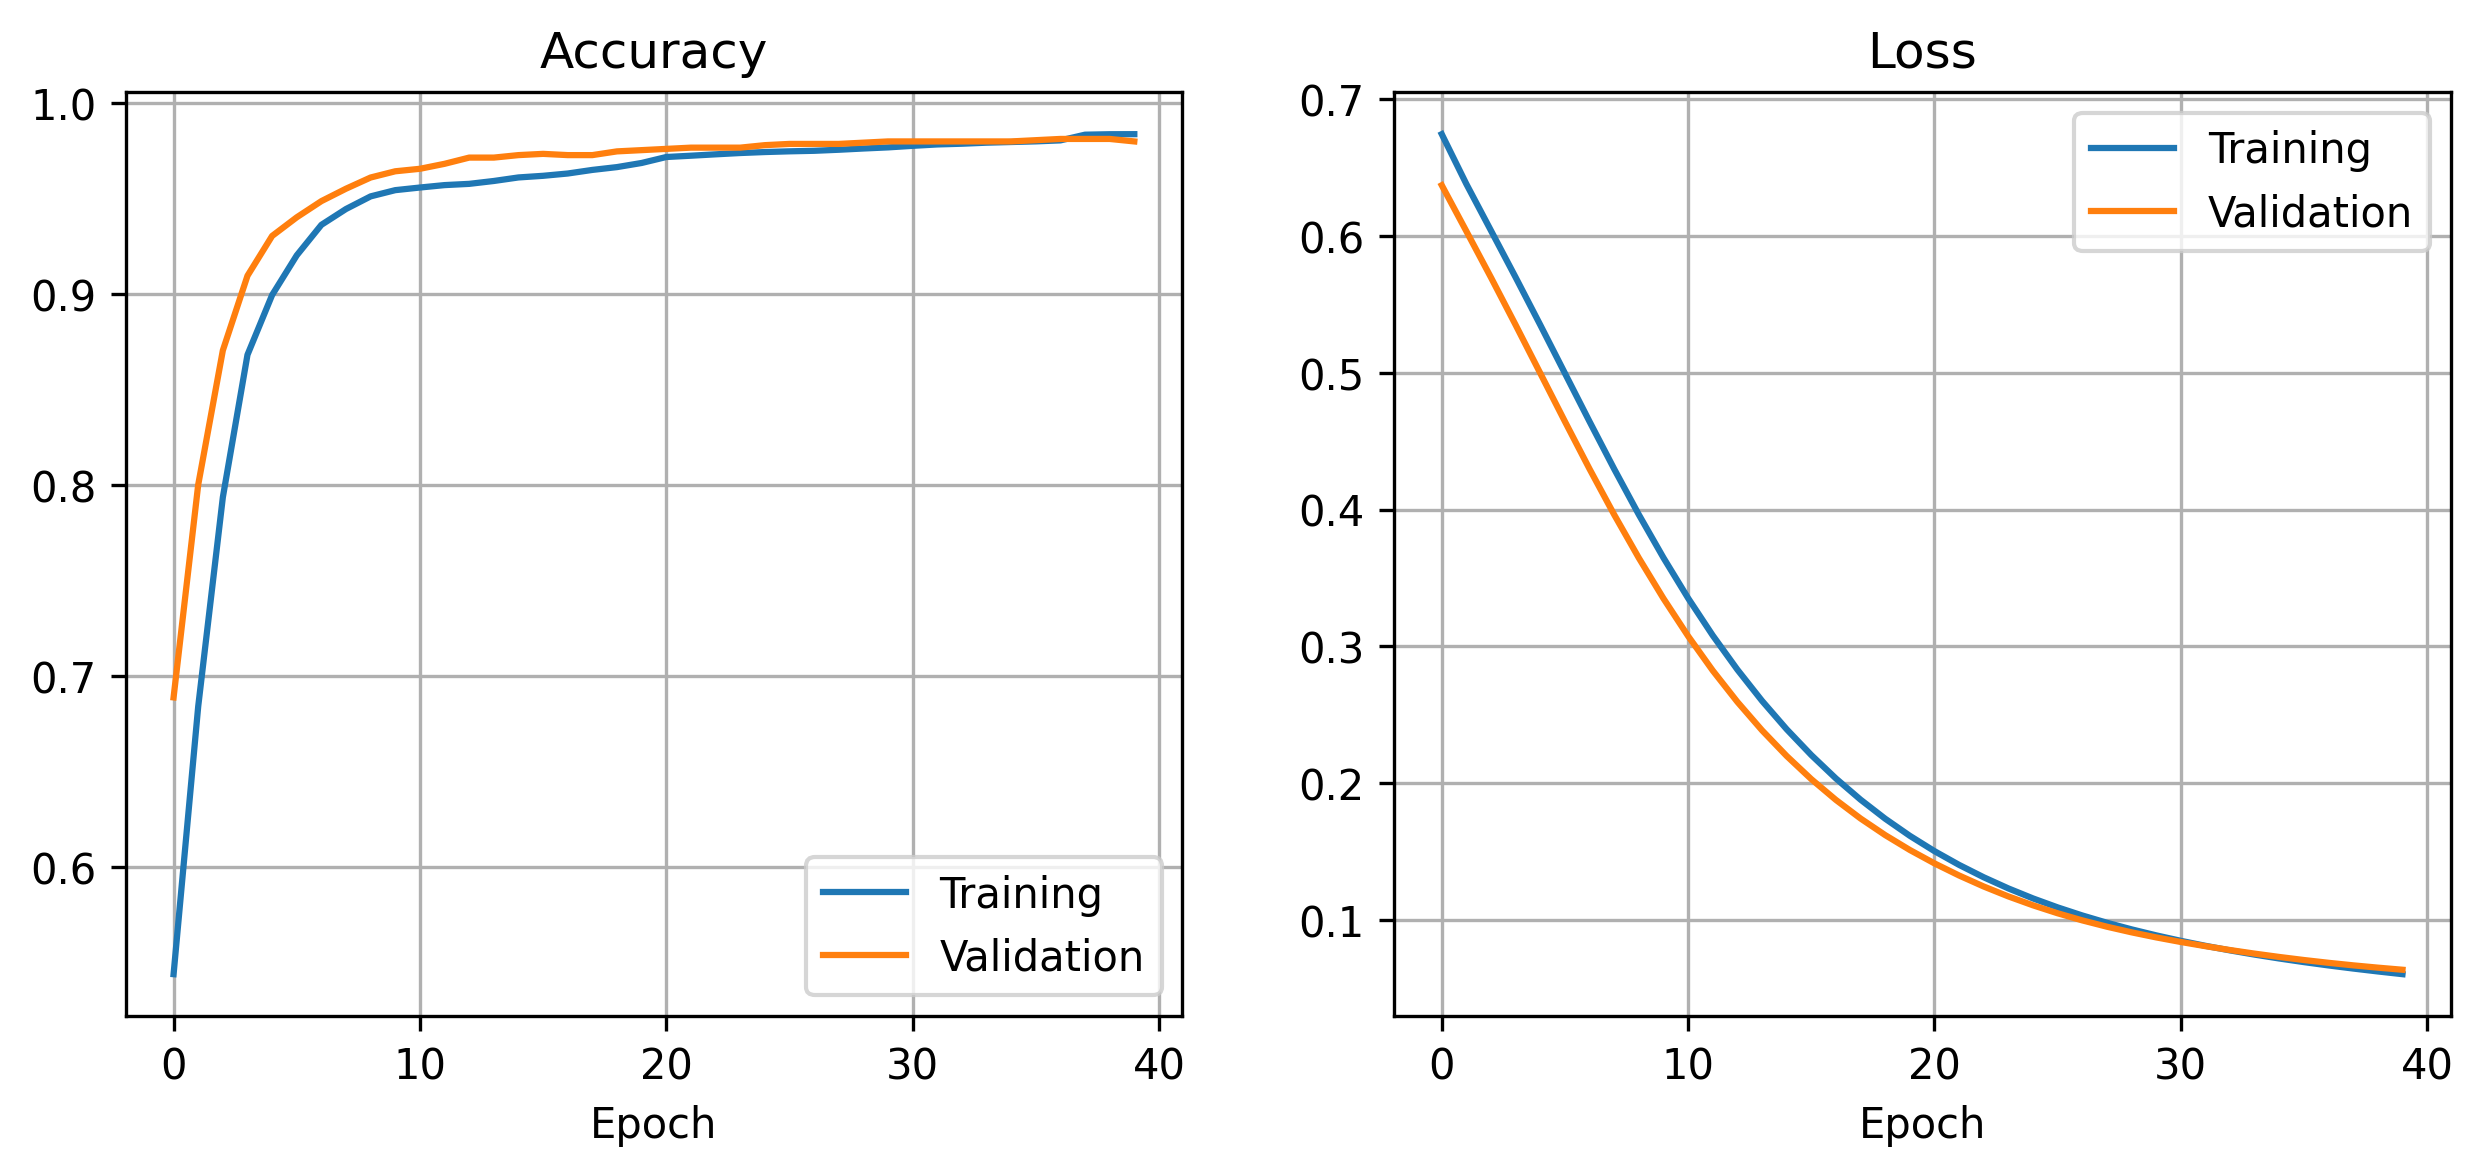

In [19]:
plot_history(training_history.history)

Wonderful!  According to the graphs, our validation accuracy tracks very well with our training accuracy, as does the validation loss.  Additionally, it appears that we are at or very near to 100% accuracy!  Let's talk about some of the settings that we just used.

## Batch Size

The `batch_size` parameter is used to control when and how frequently the weights and biases are updated in the neurons.  With no value set, every parameter in the model will be updated after every training example is run through and less is measured between the prediction and the ground truth label.  This will slow down the training process for two reasons:

 * The algorithm is pausing to perform backpropagation at every training step
 * We aren't taking advantage of the massive parallelization that's possible using linear algebra rules since we are working with just one row of data at a time.

Updating the parameters after every row of data will tend to allow noise in our data to have a stronger influence.  When we train in batches, the noise tends to get smoothed out.

Based on the above, we could incorrectly assume that we *always* want to set the `batch_size` parameter to the highest possible value, which will be governed by the RAM on your system or on your GPU.  ***This is an incorrect assumption!***. While it is generally true that setting the `batch_size` to a large value will result in very fast epochs, this is achieved by updating the parameters infrequently.  While this can dampen noise, it can also make it much more difficult for the network to learn generalized features since *everything* is dampened.  This will force the model to take many more epochs to converge (if ever) in most cases.

What value, then, should we use for the `batch_size`?  As a rule of thumb, about 30-40 or so.  We will often use the number 32, simply because it falls between this range.  This is not a hard rule, however!  You may find that in specific cases using a much smaller or much larger number results in better training performance for your specific problem.

## Epochs

As you already know, the number of epochs is the number of times that we run the entire training set through the network and update the parameters appropriately.  This is another situation where we can feel as though *more is better*.  This is not necessarily true.

The data and network that we are working with at the moment converges to a solution very quickly.  It is unlikely that training for additional epochs will significantly change the accuracy or loss.  *However,* it is much more typical that our network will reach a point where our loss suddenly begins to increase.  If we were to continue training after this point, we are almost certainly overfitting.  Even though our accuracy numbers *appear* to increase (they might not...), our accuracy with real-world data is likely *decreasing* because we are no longer generalizing, we are memorizing.

In the end, though, we still need to check out our model with test data.

# <img src="../images/task.png" width=20 height=20> Task 3.14

Use the `model.evaluate()` method to evaluate the performance of the model using the test dataset that we prepared earlier.



In [20]:
(loss, accuracy) = model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {loss}\tAccuracy: {accuracy*100}%")

Loss: 0.07397614419460297	Accuracy: 98.50000143051147%



# <img src="../images/task.png" width=20 height=20> Task 3.15

* Recompile and retrain the model we have just built, this time using a `batch_size` of 32 and 10 `epochs`.
* Plot the training accuracy and loss.
* Use the `model.evaluate()` method to evaluate the performance of the model using the test dataset that we prepared earlier.



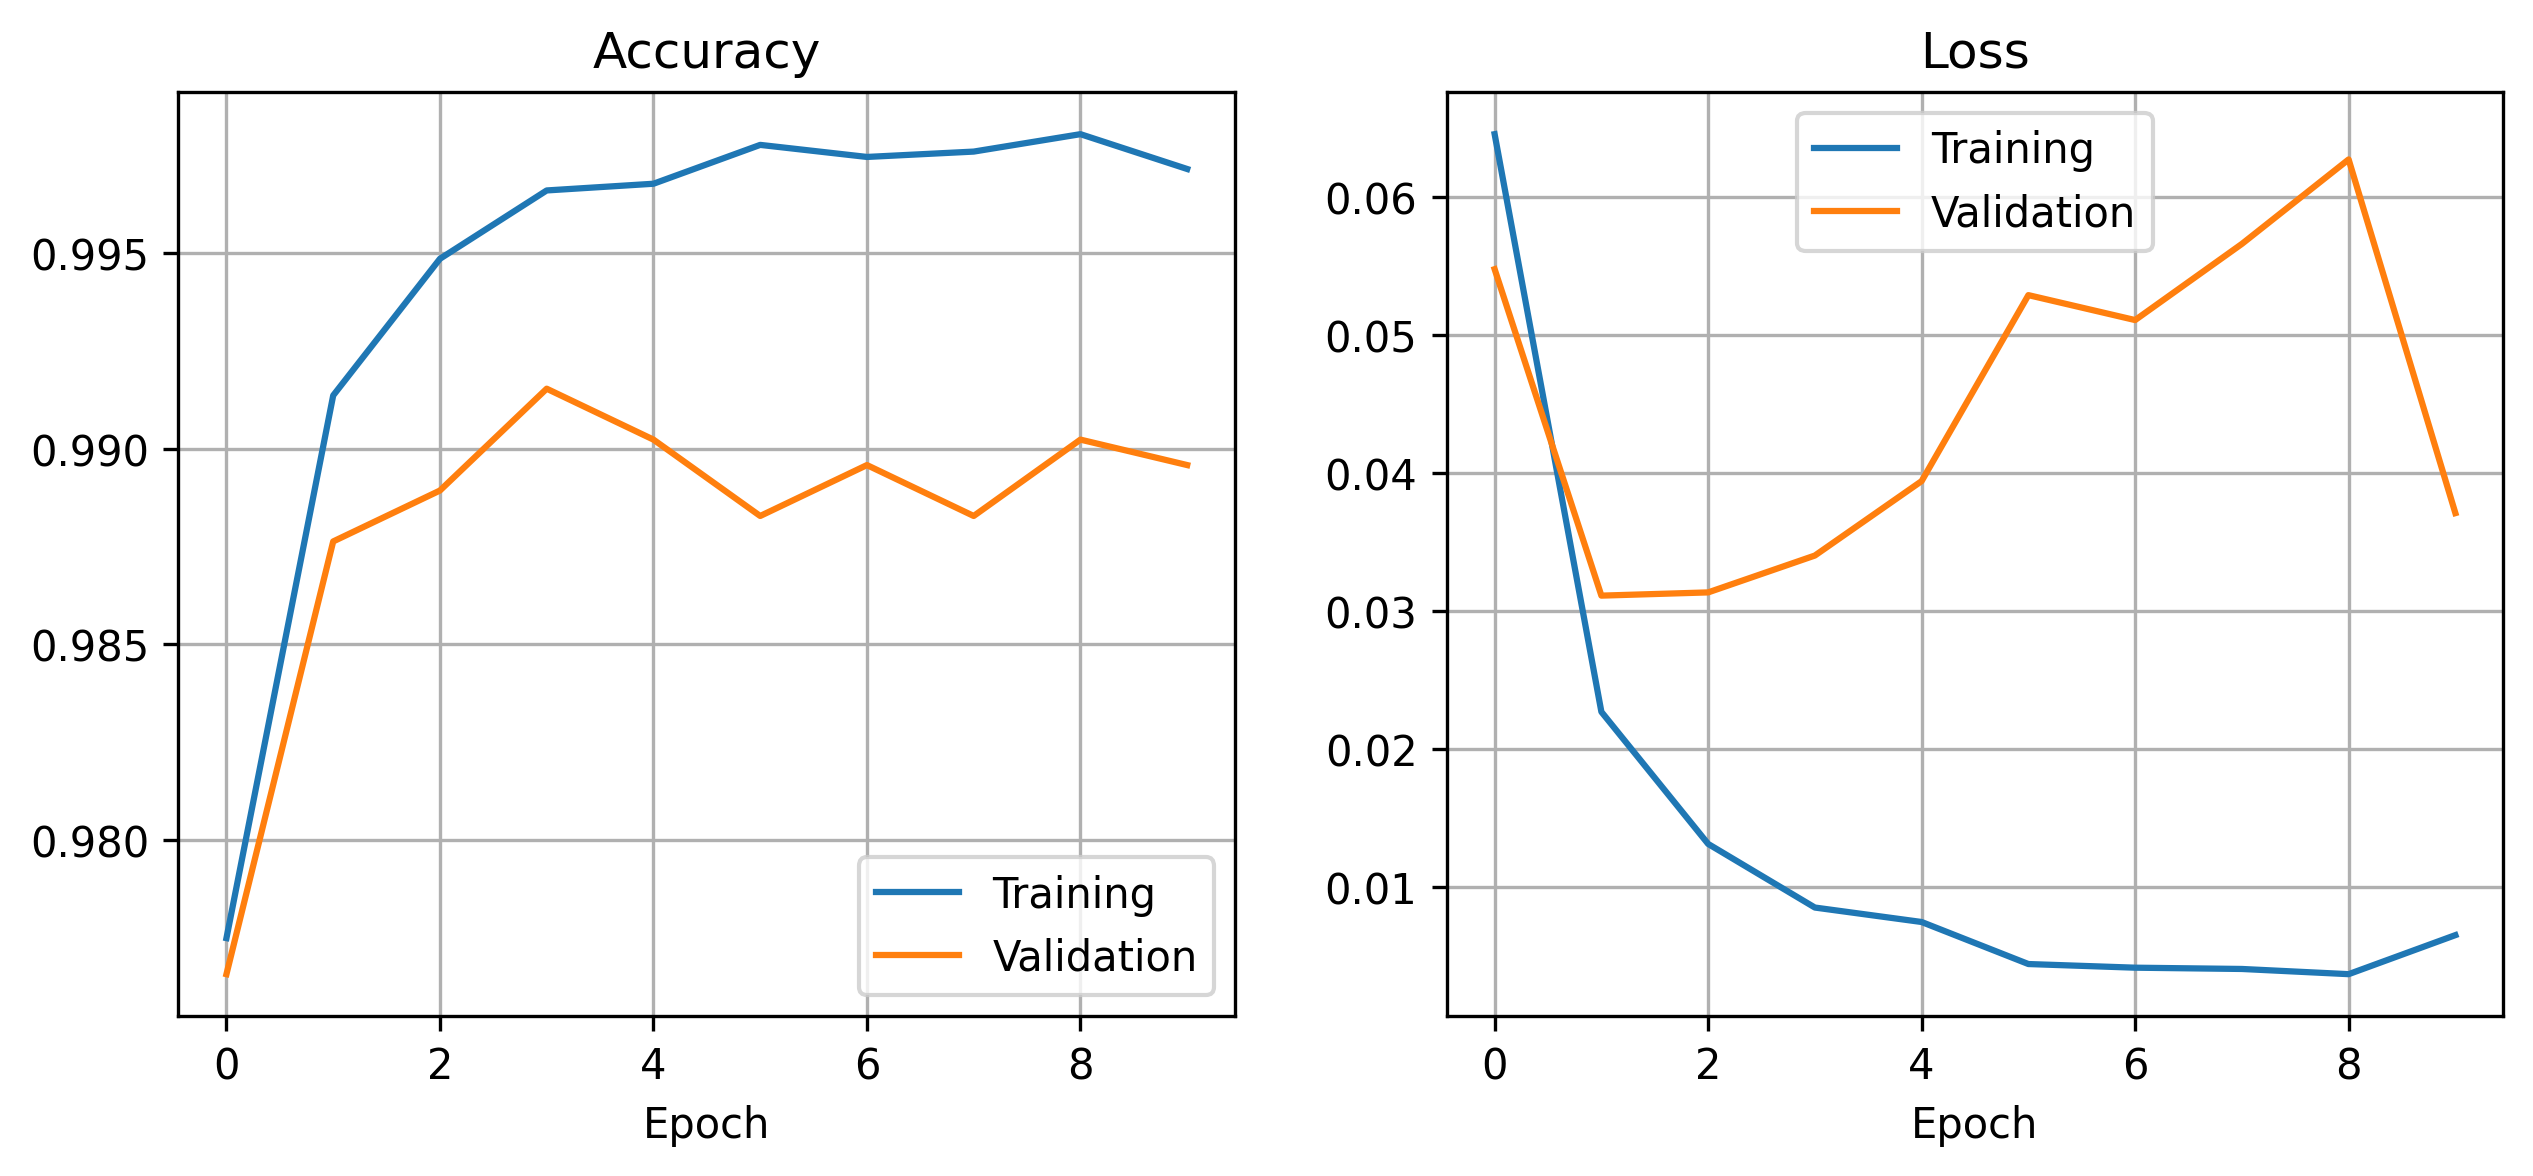

Loss: 0.059137724339962006	Accuracy: 98.7999975681305%


In [21]:
tf.random.set_seed(42)
model = models.Sequential()
model.add(layers.Dense(64, name="Input_Layer", activation='relu', input_shape=(WordsToWorkWith,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, name="Output_Layer", activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_history = model.fit(x_train, y_train, validation_split=0.05, epochs = 10, batch_size = 32, verbose=False)

plot_history(training_history.history)
(loss, accuracy) = model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {loss}\tAccuracy: {accuracy*100}%")

Notice the loss value during validation is "bouncing" up and down, as is the validation accuracy.  While this example isn't very bad, this pattern indicates there is some measure of overfitting occurring.  Let's adjust some of the configuration of how we are training the model.

# <img src="../images/task.png" width=20 height=20> Task 3.16

* Recompile and retrain the model we have just built, this time using a `batch_size` of 64 and 25 `epochs`.
* Plot the training accuracy and loss.
* Use the `model.evaluate()` method to evaluate the performance of the model using the test dataset that we prepared earlier.



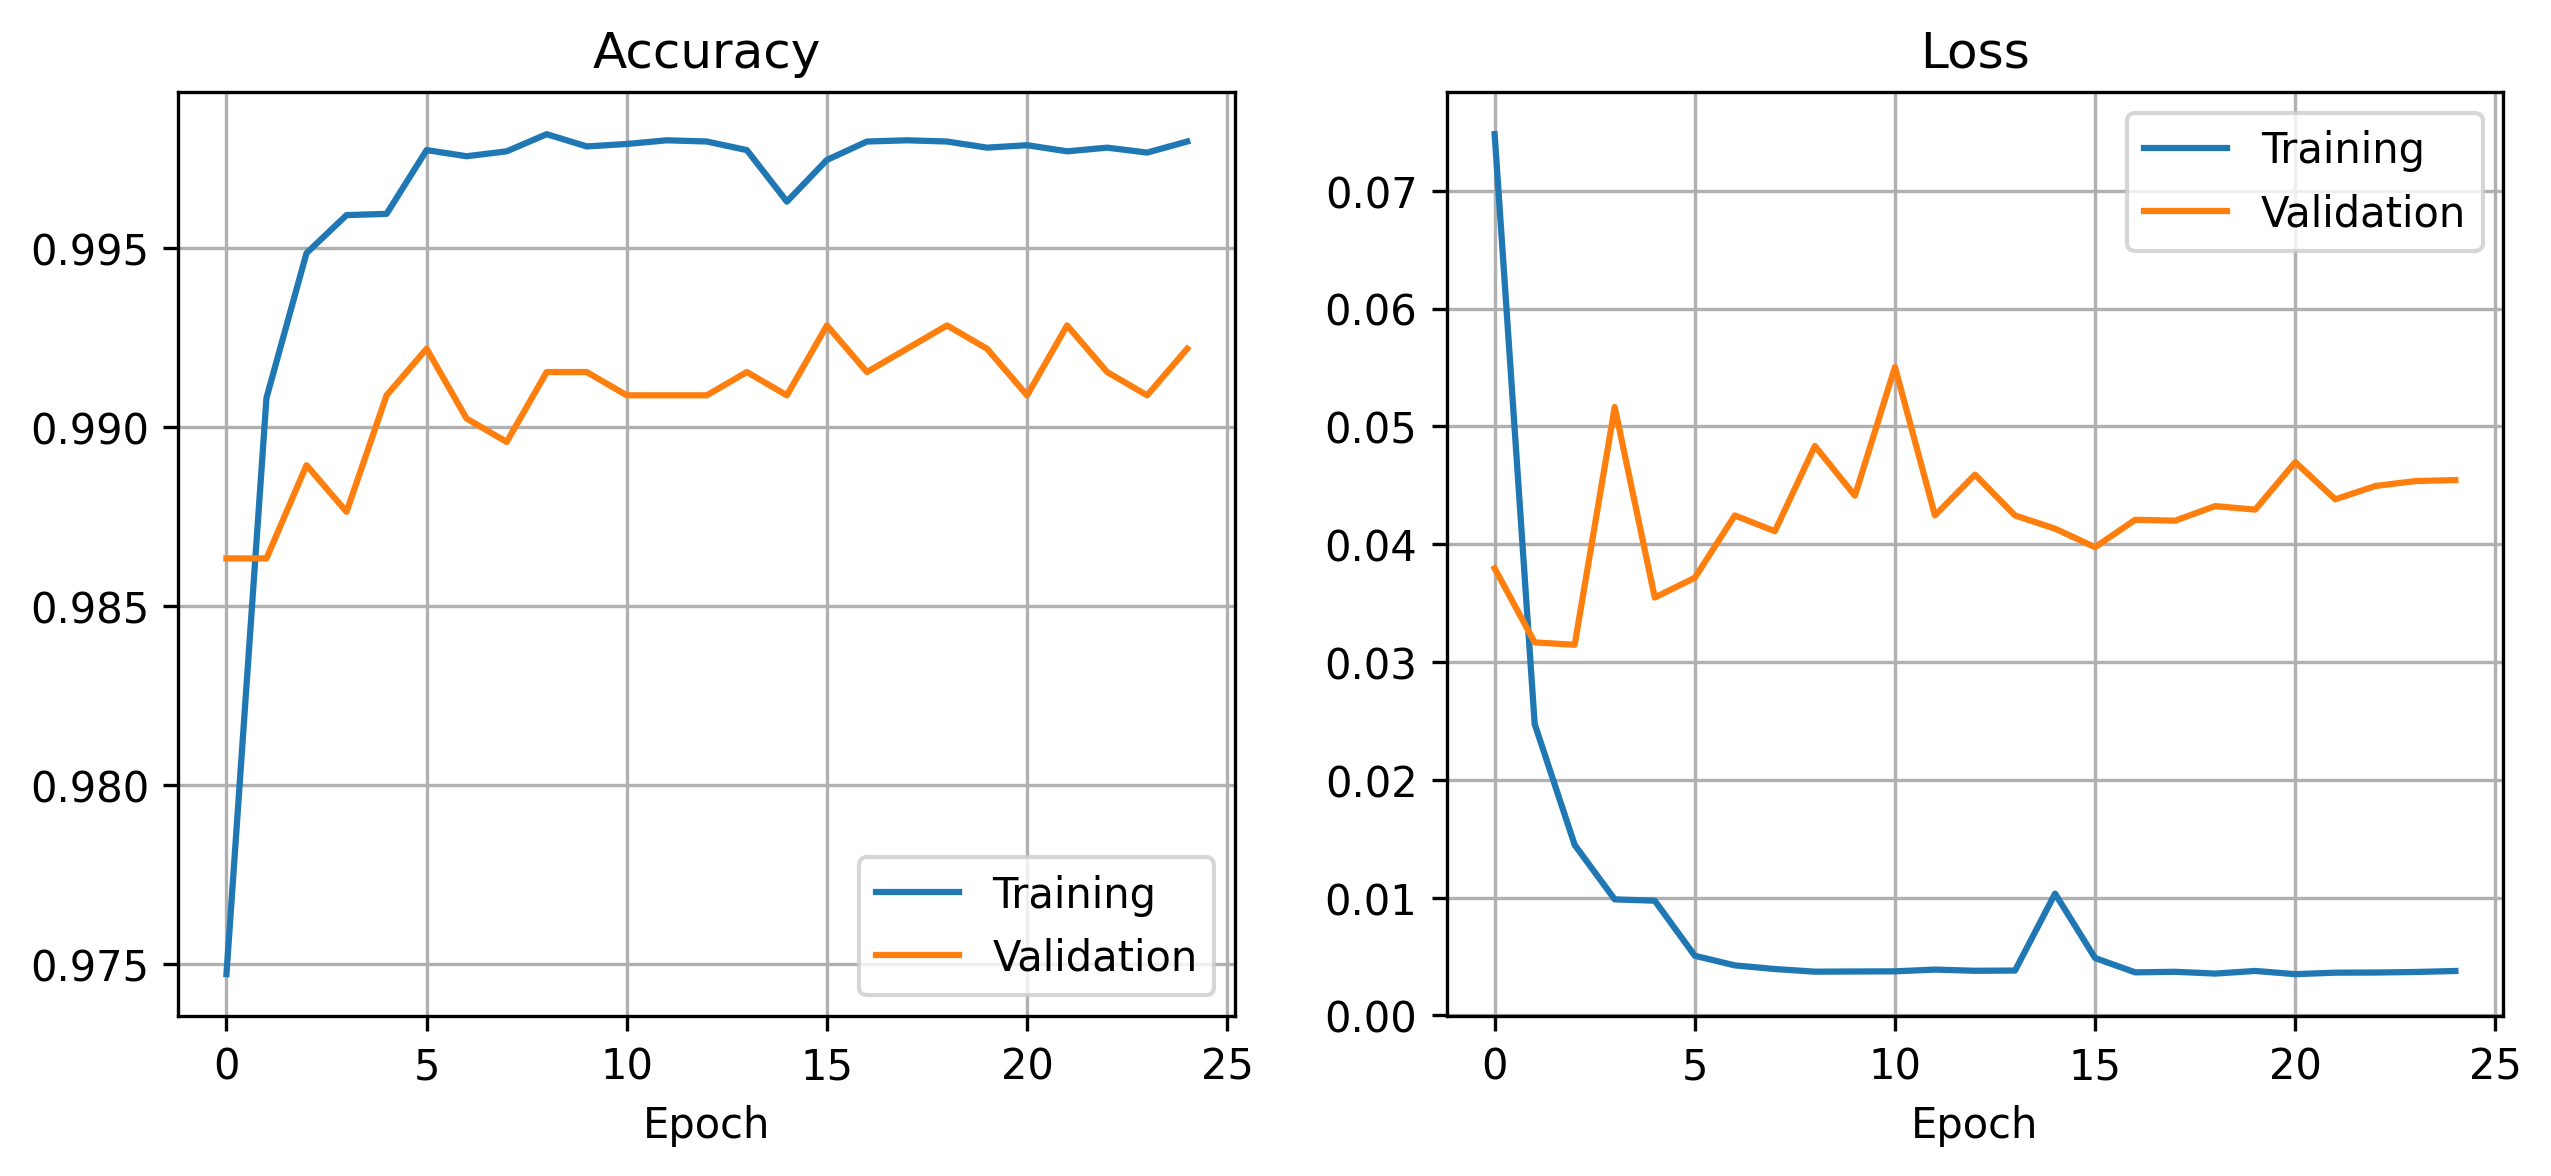

Loss: 0.10249118506908417	Accuracy: 99.00000095367432%


In [22]:
tf.random.set_seed(42)
model = models.Sequential()
model.add(layers.Dense(64, name="Input_Layer", activation='relu', input_shape=(WordsToWorkWith,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, name="Output_Layer", activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_history = model.fit(x_train, y_train, validation_split=0.05, epochs = 25, batch_size = 64, verbose=False)

plot_history(training_history.history)
(loss, accuracy) = model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {loss}\tAccuracy: {accuracy*100}%")

We still see some of this behavior, so more tuning might be beneficial.  We might also try modifying the model somewhat to make it more add or remove bias.  Still, at $99\%$, this model performs better than the best model we've built for this problem.

# Conclusion

This lab covered a lot of ground!  We have several key takeaways that you will be expected to apply in future labs:

 * How to apply the Bag of Words approach using multi-hot encoding and a dense network
 * What the impact of the batch size is on the training process
 * How to use the built in `evaluate()` method to test a model